# Final Team Project | ARIMA as a Demand Forecasting Method
BAX 453 | Yiyi Han, Jasmin Zou, Scott Virshup, Sarah Gustafson, and Dane Hamlett

As bike sharing programs are gaining momentum in the ride sharing industry, it is imperative for companies to understand how to improve the forecasting methodology they leverage to predict demand. Having an adequate number of bikes at a specfic station, on any given day of the week, is critical to ensuring existing customers and potential customers will have a bike ready when they need it.
<p></p>
This analysis aims to implement multiple time-series forecasting methods, with the goal of finding an optimal model to predict demand (# of trips). We have leveraged publicly available data from <a href="https://www.fordgobike.com/system-data" target="_blank">Ford GoBike</a>, to inform our models, and will be stepping through 7 unique forecasting methods, to determine which model has the lowest root-mean-squared error.

<img width="100%" src="https://raw.githubusercontent.com/danehamlett/UC_Davis/master/BAX_453/ford_go_bike_map.png"><img>
<p>https://member.fordgobike.com/map/</p>

## The Initial Code

In [208]:
## Import Libraries
import pymssql
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

We will establish a connection to an offline SQL Database (<a href="https://www.microsoft.com/en-us/sql-server/sql-server-2017" target="_blank">Microsoft SQL Server</a>), which contains the raw Ford GoBike trip data from 2017, through 2018. We have blended this data with neighborhood details, that have been generated from a <a href="https://www.doogal.co.uk/BatchReverseGeocoding.php" target="_blank">Batch Reverse Geocoding Application</a>, and a list of <a href="http://sanfranguide.com/zip-codes/" target="_blank">San Francisco Neighborhoods and Zip Codes</a>.
<p></p>
Here is the T-SQL Code used to create the object we will be using for our analysis:

In [209]:
## Establish Connection to Local MS SQL Server Instance, and Open a Cursor
conn = pymssql.connect(host='107.3.137.131:2015', user='svc_hopper', password='User#1', database='UCDavisDB')

## SELECT * Query from the Table that Contains the Ford GoBike Data
## We Will Leverage the Data from a Single Location for Modeling Purposes
sql = "SELECT * FROM [UCDavisDB].[dbo].[vwBike_Data_Time_Series] WHERE Neighborhood = 'Embarcadero South '"

## Convert Results into a Pandas Dataframe
tseries_df = pd.read_sql(sql,conn)

## Close the MS SQL Server Connection
conn.close()

In [210]:
## Preview the Results
tseries_df.head(5)

,Trips,Date_Time,Neighborhood
0,4,2017-06-28 09:00:00,Embarcadero South
1,21,2017-06-28 10:00:00,Embarcadero South
2,8,2017-06-28 11:00:00,Embarcadero South
3,23,2017-06-28 12:00:00,Embarcadero South
4,12,2017-06-28 13:00:00,Embarcadero South


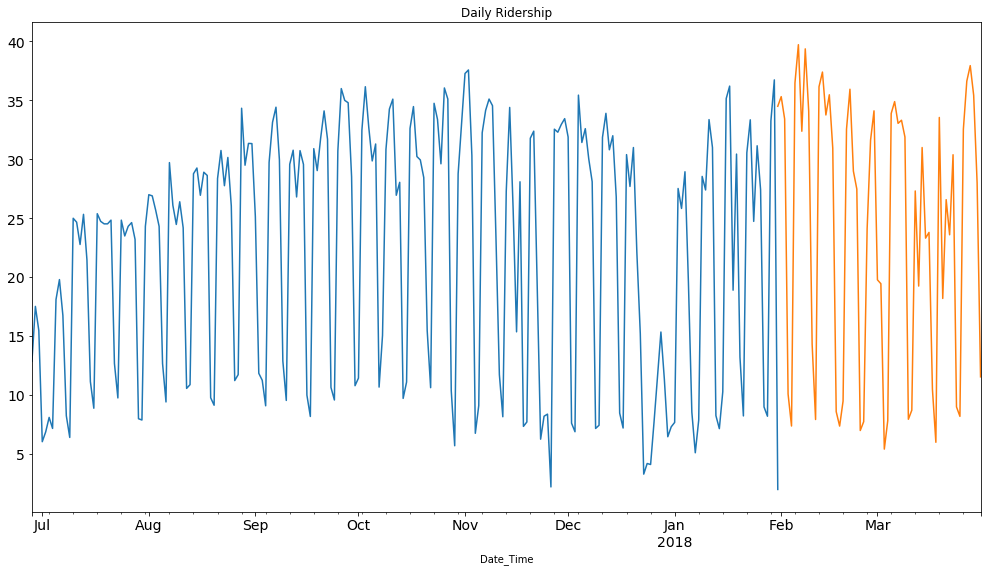

In [211]:
## Create a Training and Test Data Set for Modeling
## Index 4,182 Marks January 31, 2018
train = tseries_df[0:4182] 
test = tseries_df[4182:]

## We will Aggregate the Dataset at the Daily Level
tseries_df.Timestamp = pd.to_datetime(tseries_df.Date_Time,format='%Y-%m-%d %H:%M:%S') 
tseries_df.index = tseries_df.Timestamp 
tseries_df = tseries_df.resample('D').mean()
train.Timestamp = pd.to_datetime(train.Date_Time,format='%Y-%m-%d %H:%M:%S') 
train.index = train.Timestamp 
train = train.resample('D').mean() 
test.Timestamp = pd.to_datetime(test.Date_Time,format='%Y-%m-%d %H:%M:%S')
test.index = test.Timestamp 
test = test.resample('D').mean()

## Let's Plot the Actual Data
train.Trips.plot(figsize=(17,9), title= 'Daily Ridership', fontsize=14)
test.Trips.plot(figsize=(17,9), title= 'Daily Ridership', fontsize=14)
plt.show()

## The Modeling

### Naive Forecasting Approach
#### A forecasting method that assumes that the next expected point is equal to the last observed point.

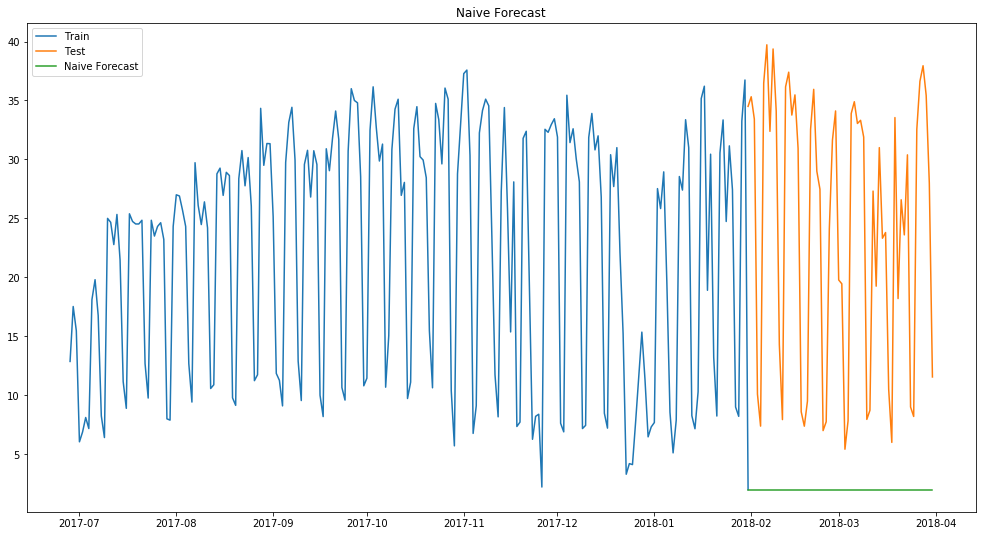

In [212]:
## Setting up the Naive Forecasting Model
dd= np.asarray(train.Trips)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(17,9))
plt.plot(train.index, train['Trips'], label='Train')
plt.plot(test.index,test['Trips'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [213]:
## Find the Root-Mean-Squared Error
naive_rms = sqrt(mean_squared_error(test.Trips, y_hat.naive))
print(naive_rms)

25.114543118794586


### Simple Average Approach
#### A forecasting method that assumes that the next expected point is equal to the average of all of the previously observed points.

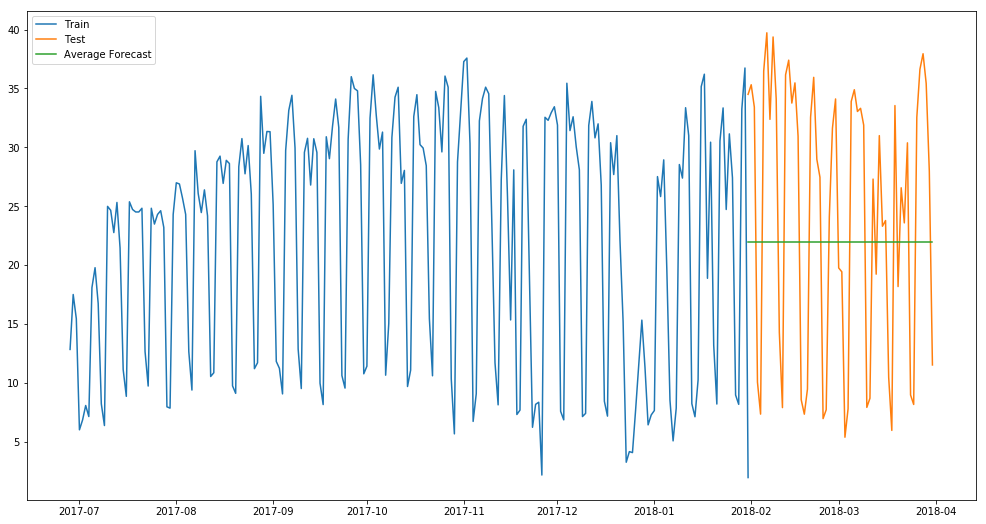

In [214]:
## Setting up the Simple Average Model
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Trips'].mean()
plt.figure(figsize=(17,9))
plt.plot(train['Trips'], label='Train')
plt.plot(test['Trips'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Average Forecast')
plt.legend(loc='best')
plt.show()

In [215]:
## Find the Root-Mean-Squared Error
sma_rms = sqrt(mean_squared_error(test.Trips, y_hat_avg.avg_forecast))
print(sma_rms)

11.65500112696428


### Moving Average Approach
#### A forecasting method that assumes that the next expected point is equal to a rolling average of all of the previously observed points within a specified period.

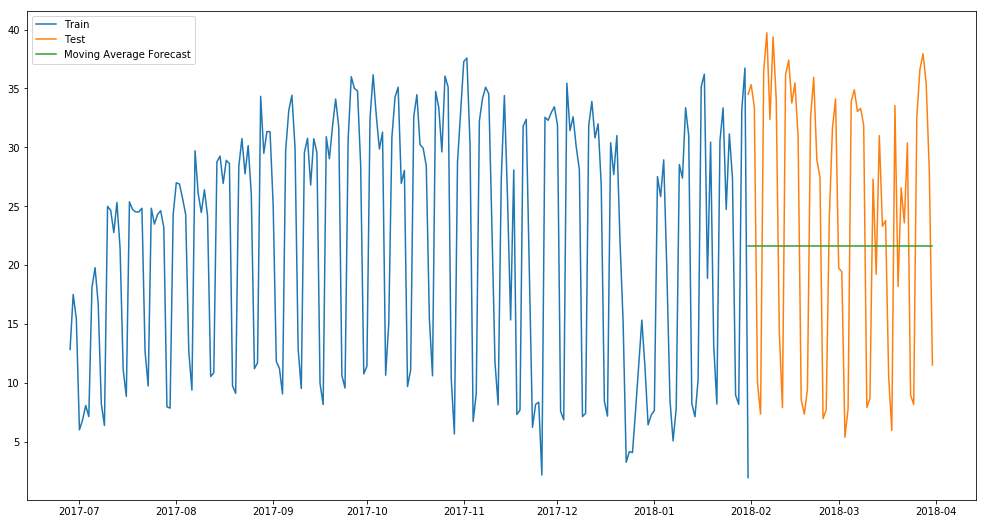

In [216]:
## Setting up the Moving Average Model
y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train['Trips'].rolling(30).mean().iloc[-1]
plt.figure(figsize=(17,9))
plt.plot(train['Trips'], label='Train')
plt.plot(test['Trips'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

In [217]:
## Find the Root-Mean-Squared Error
ma_rms = sqrt(mean_squared_error(test.Trips, y_hat_avg.moving_avg_forecast))
print(ma_rms)

11.730177119546202


### Simple Exponential Smoothing Approach
#### A forecasting method that assumes that the next expected point is equal to the weighted average of the previously observed points, where smaller weights are applied to older observervations.

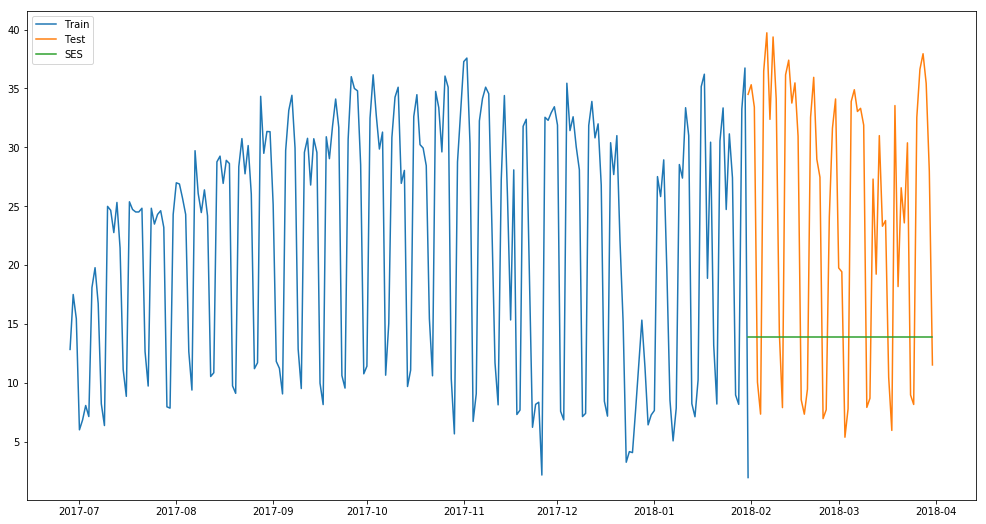

In [218]:
## Setting up the Simple Exponential Smoothing Model
y_hat_avg = test.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['Trips'])).fit(smoothing_level=0.6,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(test))
plt.figure(figsize=(17,9))
plt.plot(train['Trips'], label='Train')
plt.plot(test['Trips'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()

In [219]:
## Find the Root-Mean-Squared Error
ems_rms = sqrt(mean_squared_error(test.Trips, y_hat_avg.SES))
print(ems_rms)

15.448039312003761


### Holt's Linear Trend
#### A forecasting method based off of the decomposition of the observed data into three components: Trend, Seasonality and Residual.  Assuming a dataset will follow a linear trend, this can be an ideal forecasting method.

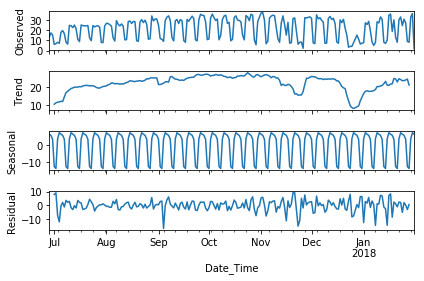

In [220]:
## Setting up the Holt's Linear Trend Model
sm.tsa.seasonal_decompose(train.Trips).plot()
result = sm.tsa.stattools.adfuller(train.Trips)
plt.show()

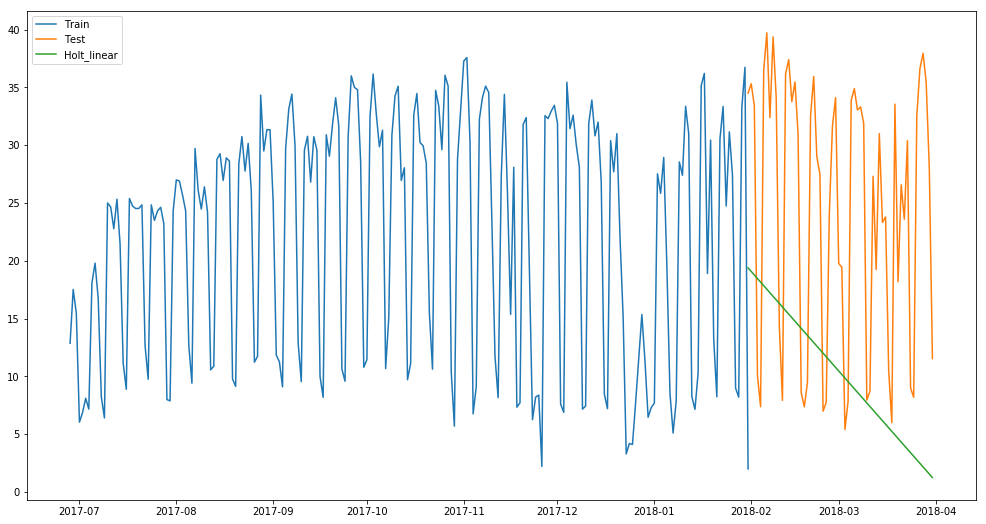

In [221]:
## Continue Setting up the Holt's Linear Trend Model
y_hat_avg = test.copy()
fit1 = Holt(np.asarray(train['Trips'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(test))
plt.figure(figsize=(17,9))
plt.plot(train['Trips'], label='Train')
plt.plot(test['Trips'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()

In [222]:
## Find the Root-Mean-Squared Error
hlt_rms = sqrt(mean_squared_error(test.Trips, y_hat_avg.Holt_linear))
print(hlt_rms)

18.454507134781664


### Holt-Winters Method
#### A forecasting method that takes into account seasonality and trend as a means to predict future prices. This method applies exponential smoothing to the seasonal components in addition to level and trend

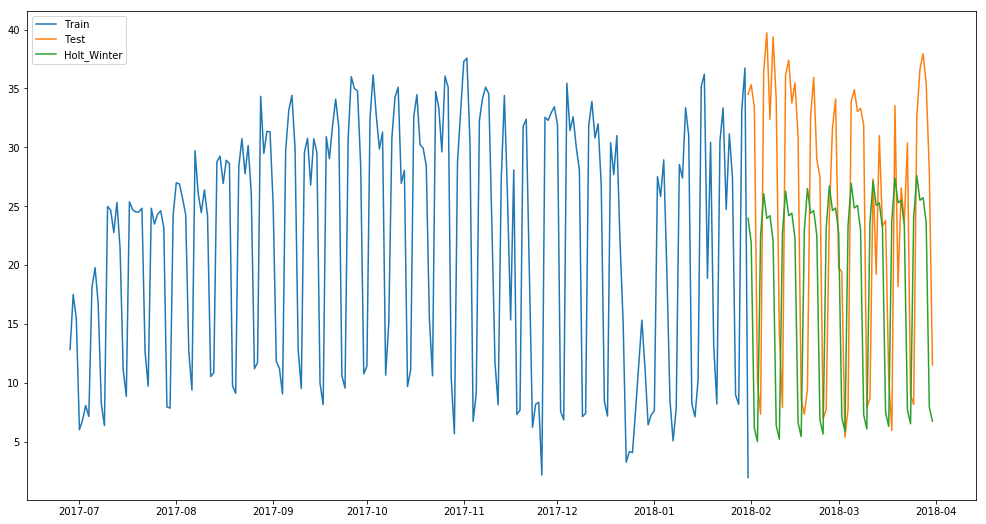

In [223]:
## Setting up the Holt-Winters Model
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['Trips']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(17,9))
plt.plot( train['Trips'], label='Train')
plt.plot(test['Trips'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [224]:
## Find the Root-Mean-Squared Error
hwm_rms = sqrt(mean_squared_error(test.Trips, y_hat_avg.Holt_Winter))
print(hwm_rms)

12.723473480427126


### (S)ARIMA Method
#### A forecasting method that also takes into account the seasonality of a specific dataset, and the next expected point is regressed against the previously observed values.

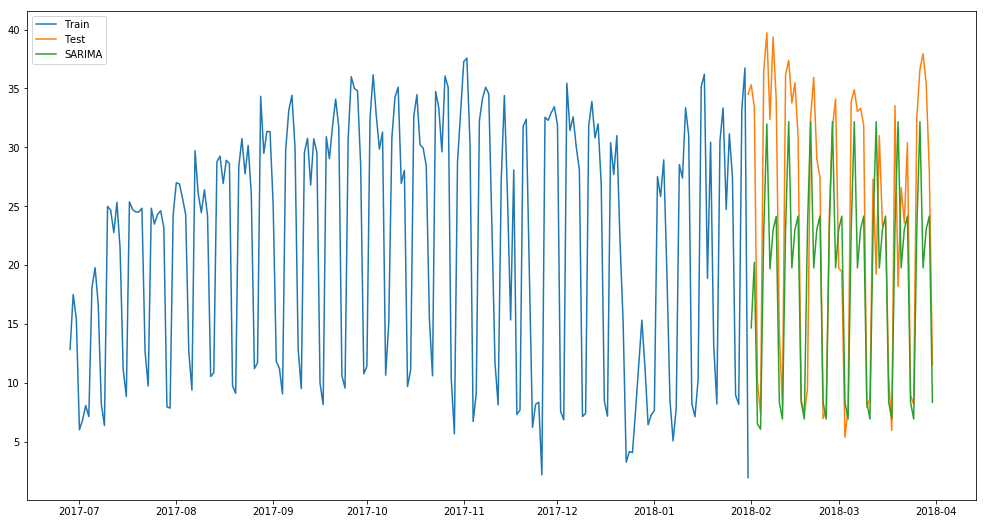

In [225]:
## Setting up the (S)ARIMA Method
y_hat_avg = test.copy()
fit1 = sm.tsa.statespace.SARIMAX(train.Trips,seasonal_order=(0,1,1,7)).fit()
y_hat_avg['SARIMA'] = fit1.predict(start="2018-2-1", end="2018-3-31", dynamic=True)
plt.figure(figsize=(17,9))
plt.plot( train['Trips'], label='Train')
plt.plot(test['Trips'], label='Test')
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()

In [226]:
## Replace NULL Value
y_hat_avg.SARIMA = y_hat_avg.SARIMA.fillna(test.Trips[0])

## Find the Root-Mean-Squared Error
ar_rms = sqrt(mean_squared_error(test.Trips, y_hat_avg.SARIMA))
print(ar_rms)

8.715152800199132


## The Results

<img width="50%" src="https://raw.githubusercontent.com/danehamlett/UC_Davis/master/BAX_453/bike_interpretation.png"><img>

## References

- https://www.doogal.co.uk/BatchReverseGeocoding.php
- http://sanfranguide.com/zip-codes/
- https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/
- https://www.fordgobike.com/system-data
- https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average
- http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html